In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append(os.path.abspath("../.."))  # Adds the project root to sys.path
import numpy as np 
import math
import tensorflow as tf

from recommenders.datasets.linear_regression import *

In [3]:
save_interaction_values()

[47608, 52026, 54268, 55284]


In [9]:
Y, R, num_products = get_data()

Y (117, 4) R (117, 4)
num_products 117
num_users 4


In [5]:
# my_ratings = np.zeros(num_products)

# my_ratings[0] = 5 # Bosch, Burgija
# my_ratings[1] = 1 # Bosch, Testera
# my_ratings[2] = 1 # Bosch, Testera

# # Add new user ratings to Y 
# Y = np.c_[my_ratings, Y]

# # Add new user indicator matrix to R
# R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset


In [4]:
# test_recency_bonus(100, 20)

In [10]:
num_users = Y.shape[1] # FT: It's mandatory because we could add one more user to the matrix

X, W, b = initialize_tf_variables(num_users, num_products)

Training loss at iteration 0: 12299.324
Training loss at iteration 20: 1454.358
Training loss at iteration 40: 355.676
Training loss at iteration 60: 115.395
Training loss at iteration 80: 48.676
Training loss at iteration 100: 25.268
Training loss at iteration 120: 15.190
Training loss at iteration 140: 10.106
Training loss at iteration 160: 7.236
Training loss at iteration 180: 5.497
Training loss at iteration 200: 4.404
Training loss at iteration 220: 3.708
Training loss at iteration 240: 3.264
Training loss at iteration 260: 2.982
Training loss at iteration 280: 2.804
Training loss at iteration 300: 2.692
Training loss at iteration 320: 2.624
Training loss at iteration 340: 2.582
Training loss at iteration 360: 2.556
Training loss at iteration 380: 2.542
Training loss at iteration 400: 2.533
Training loss at iteration 420: 2.528
Training loss at iteration 440: 2.525
Training loss at iteration 460: 2.524
Training loss at iteration 480: 2.523
Training loss at iteration 500: 2.523
Tra

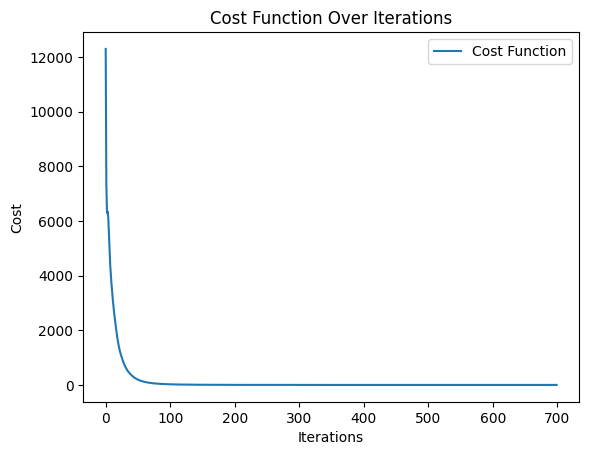

In [11]:
Ynorm, Ymean = normalize_ratings(Y, R)
calculate_parameters(X, W, b, Ynorm, R, iterations=700, lambda_=1, learning_rate=0.1)

In [ ]:
# product_names = load_csv_list('../../recommenders/datasets/pa/product_names.csv')

# Make a prediction using trained weights and biases
predictions_normalized = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

#restore the mean
predictions = predictions_normalized + Ymean

rmse(Y, predictions, R)

my_predictions = predictions[:,0]

# sort predictions
ix = tf.argsort(my_predictions, direction='DESCENDING')

for i in range(len(my_predictions)):
    print(f'Predict: {my_predictions[i]:0.5f}, Original: {predictions[i,0]:0.5f}')
    # if my_ratings[i] > 0:
    #     print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {product_names[i]}')

RMSE score: 0.09287067115889582
Predict: 4.74, Original: 4.74
Predict: 5.02, Original: 5.02
Predict: 4.52, Original: 4.52
Predict: 4.53, Original: 4.53
Predict: 4.52, Original: 4.52
Predict: 4.52, Original: 4.52
Predict: 4.74, Original: 4.74
Predict: 4.74, Original: 4.74
Predict: 4.53, Original: 4.53
Predict: 4.52, Original: 4.52
Predict: 4.52, Original: 4.52
Predict: 7.05, Original: 7.05
Predict: 5.11, Original: 5.11
Predict: 4.55, Original: 4.55
Predict: 4.55, Original: 4.55
Predict: 4.55, Original: 4.55
Predict: 4.52, Original: 4.52
Predict: 5.57, Original: 5.57
Predict: 4.52, Original: 4.52
Predict: 4.53, Original: 4.53
Predict: 4.74, Original: 4.74
Predict: 4.53, Original: 4.53
Predict: 4.53, Original: 4.53
Predict: 5.65, Original: 5.65
Predict: 5.65, Original: 5.65
Predict: 4.74, Original: 4.74
Predict: 4.55, Original: 4.55
Predict: 4.50, Original: 4.50
Predict: 4.78, Original: 4.78
Predict: 4.50, Original: 4.50
Predict: 5.57, Original: 5.57
Predict: 5.05, Original: 5.05
Predict: